In [1]:
"""
Dataset from: https://www.kaggle.com/rakannimer/air-passengers
International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict 
the number of international airline passengers in units of 1,000. 
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.
"""

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

# load the dataset
dataframe = read_csv('AirPassengers.csv', usecols=[1])
plt.plot(dataframe)

#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as 
#input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))


######################################################
# Reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
#print('Single LSTM with hidden Dense...')
#model = Sequential()
#model.add(LSTM(64, input_shape=(None, seq_size)))
#model.add(Dense(32))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
##monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
##                        verbose=1, mode='auto', restore_best_weights=True)
#model.summary()
#print('Train...')
#########################################

#Stacked LSTM with 1 hidden dense layer
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
#model = Sequential()
#model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
#model.add(LSTM(50, activation='relu'))
#model.add(Dense(32))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mean_squared_error')
#
#model.summary()
#print('Train...')
###############################################

#Bidirectional LSTM
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
##For some sequence forecasting problems we may need LSTM to learn
## sequence in both forward and backward directions
#from keras.layers import Bidirectional
#model = Sequential()
#model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(None, seq_size)))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mean_squared_error')
#model.summary()
#print('Train...')

#########################################################
#ConvLSTM
#The layer expects input as a sequence of two-dimensional images, 
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
#print('Train...')



###############################################
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)





Using TensorFlow backend.


Shape of training set: (84, 10)
Shape of test set: (38, 10)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          19200     
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________
Train on 84 samples, validate on 38 samples
Epoch 1/100
 - 1s - loss: 0.0607 - val_loss: 0.2922
Epoch 2/100
 - 0s - loss: 0.0411 - val_loss: 0.2089
Epoch 3/100
 - 0s - loss: 0.0247 - val_l

In [2]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
print(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


[[346.99999379 304.99998716 335.99999132 339.99999783 317.99999288
  362.00000277 348.00001085 362.99998896 434.99999813 491.00002756
  505.00001948 403.99999397 359.00001333 310.00001073 337.00000838
  359.99999952 342.00000109 406.0000281  395.99998094 420.00002002
  471.99998119 548.00004318 559.00001477 462.99998197 407.00001429
  362.00000277 404.99998016 416.9999997  390.99998824 418.99997208
  461.00000959 471.99998119 535.00003745 622.00000929 606.00004499
  507.99997805 461.00000959 390.00000205]]
Train Score: 19.27 RMSE
Test Score: 50.26 RMSE


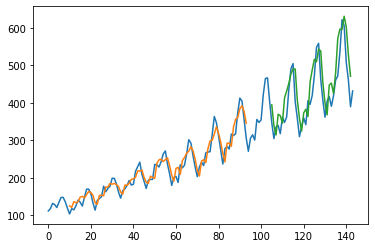

In [4]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()